# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Définition des vaccins

In [25]:
import numpy as np
import matplotlib.pyplot as plt

class ArmBernoulli:
    def __init__(self, p: float, random_state: int = 0):
        """
        Bernoulli arm
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.local_random = np.random.RandomState(random_state)
        
    def sample(self):
        return self.local_random.rand() < self.mean

    
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** $r_t$ vaut 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$


**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot**

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel bras a été choisi lors de la seconde phase ?**

In [26]:
class Naive:
    def __init__(self, T=100, N=20, K=5):
        self.T = T
        self.N = N
        self.K = K
        self.efficacy = np.zeros(K)
        self.total_saved = 0
        self.best_arm = None
        
    def train(self):
        tests_per_patients = self.N // self.K
        for vacc in range(self.K):
            for _ in range(tests_per_patients):
                self.efficacy[vacc] += MAB[vacc].sample()
                
    def exploit(self):
        self.best_arm = self.efficacy.argmax()
        for _ in range(self.T - self.N):
            self.total_saved += MAB[self.best_arm].sample()

    def get_results(self):
        print(f"Best arm: {self.best_arm}")
        print(f"Total saved: {self.total_saved}")



naive = Naive(T=100, N=20, K=5)
naive.train()
naive.exploit()
naive.get_results()


Best arm: 1
Total saved: 61


**Obtenez-vous toujours le résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?**

Non je n'obtiens pas le même résultat à chaque fois. En effet, j'obtiens souvent 1, mais aussi 0 et 3 et 4.

([<matplotlib.axis.XTick at 0x7f1cf9ebafd0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.XTick at 0x7f1cf9ebafd0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

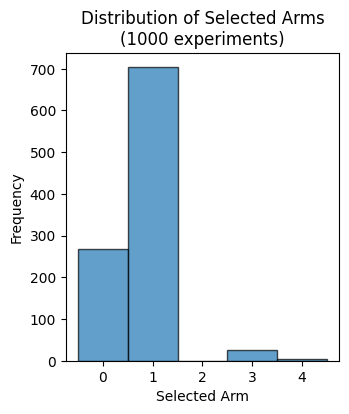

In [27]:
rep = 1000
res = np.zeros(rep)
for i in range(rep):
    naive = Naive()
    naive.train()
    naive.exploit()
    res[i] = naive.best_arm

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(res, bins=np.arange(K+1)-0.5, alpha=0.7, edgecolor='black')
plt.xlabel('Selected Arm')
plt.ylabel('Frequency')
plt.title(f'Distribution of Selected Arms\n({rep} experiments)')
plt.xticks(range(K))

Essayons avec N = 5

([<matplotlib.axis.XTick at 0x7f1cf9d80410>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

([<matplotlib.axis.XTick at 0x7f1cf9d80410>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

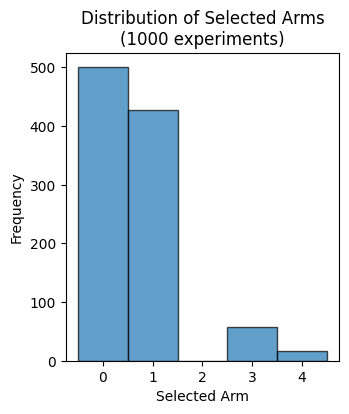

In [28]:
rep = 1000
res = np.zeros(rep)
for i in range(rep):
    naive = Naive(N = 5)
    naive.train()
    naive.exploit()
    res[i] = naive.best_arm

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(res, bins=np.arange(K+1)-0.5, alpha=0.7, edgecolor='black')
plt.xlabel('Selected Arm')
plt.ylabel('Frequency')
plt.title(f'Distribution of Selected Arms\n({rep} experiments)')
plt.xticks(range(K))



La méthode naive n'est vraiment pas une solution optimale, quand N est petit, on a tendance à donner le vaccin à l'index 0.

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez l'évolution moyenne de ce regret sur plusieurs expériences.**

True arm probabilities: ['0.417', '0.720', '0.000', '0.302', '0.147']
Optimal arm: 1 (μ* = 0.720)


True arm probabilities: ['0.417', '0.720', '0.000', '0.302', '0.147']
Optimal arm: 1 (μ* = 0.720)


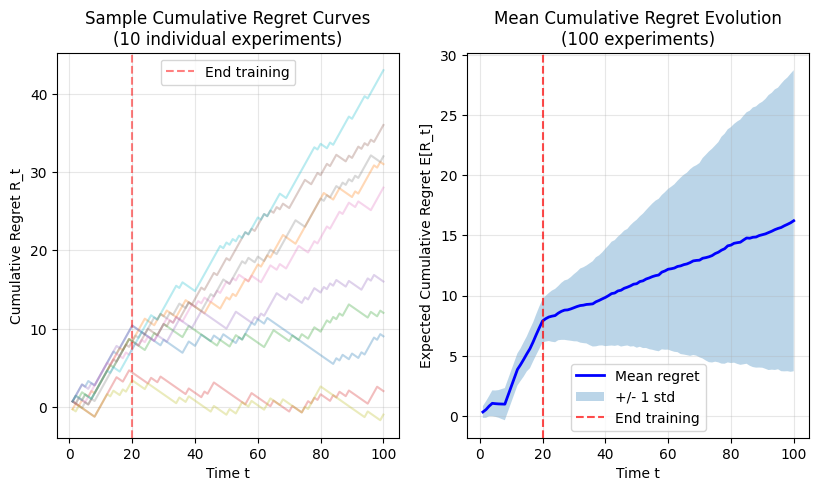

In [29]:
class NaiveWithRegret:
    def __init__(self, T=100, N=20, K=5):
        self.T = T
        self.N = N
        self.K = K
        self.efficacy = np.zeros(K)
        self.arm_counts = np.zeros(K)
        self.rewards = []
        self.actions = []
        self.best_arm = None
        self.optimal_arm = np.argmax(means)
        self.mu_star = means[self.optimal_arm]
        
    def train(self):
        tests_per_patients = self.N // self.K
        for vacc in range(self.K):
            for _ in range(tests_per_patients):
                reward = MAB[vacc].sample()
                self.efficacy[vacc] += reward
                self.arm_counts[vacc] += 1
                self.rewards.append(reward)
                self.actions.append(vacc)
                
    def exploit(self):
        self.best_arm = self.efficacy.argmax()
        for _ in range(self.T - self.N):
            reward = MAB[self.best_arm].sample()
            self.arm_counts[self.best_arm] += 1
            self.rewards.append(reward)
            self.actions.append(self.best_arm)
    
    def calculate_regret_evolution(self):
        cumulative_regret = []
        optimal_reward_so_far = 0
        actual_reward_so_far = 0
        
        for t in range(self.T):
            optimal_reward_so_far += self.mu_star
            actual_reward_so_far += self.rewards[t]
            regret_t = optimal_reward_so_far - actual_reward_so_far
            cumulative_regret.append(regret_t)
            
        return cumulative_regret


num_experiments = 100
T = 100
all_regrets = np.zeros((num_experiments, T))


print("True arm probabilities:", [f"{m:.3f}" for m in means])
print(f"Optimal arm: {np.argmax(means)} (μ* = {np.max(means):.3f})")

for exp in range(num_experiments):
    for i, mab in enumerate(MAB):
        mab.local_random = np.random.RandomState(exp * K + i)
    
    naive = NaiveWithRegret(T=T, N=20, K=5)
    naive.train()
    naive.exploit()
    
    regret_evolution = naive.calculate_regret_evolution()
    all_regrets[exp, :] = regret_evolution


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for i in range(min(10, num_experiments)):
    plt.plot(range(1, T+1), all_regrets[i, :], alpha=0.3)
plt.xlabel('Time t')
plt.ylabel('Cumulative Regret R_t')
plt.title('Sample Cumulative Regret Curves\n(10 individual experiments)')
plt.grid(True, alpha=0.3)
plt.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='End training')
plt.legend()

plt.subplot(1, 3, 2)
mean_regret = np.mean(all_regrets, axis=0)
std_regret = np.std(all_regrets, axis=0)
time_steps = range(1, T+1)

plt.plot(time_steps, mean_regret, 'b-', linewidth=2, label='Mean regret')
plt.fill_between(time_steps, 
                 mean_regret - std_regret, 
                 mean_regret + std_regret, 
                 alpha=0.3, label='+/- 1 std')
plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='End training')
plt.xlabel('Time t')
plt.ylabel('Expected Cumulative Regret E[R_t]')
plt.title(f'Mean Cumulative Regret Evolution\n({num_experiments} experiments)')
plt.legend()
plt.grid(True, alpha=0.3)


## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$$ où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?**

Car a chaque step on calcule le meilleur vaccin. donc pas besoin d'entrainement. Le terme qui favorise l'exploration et Bt car il est plus grand pour les bras moins utilisé et Xt est plus grand pour celles plus utilisés.

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

Running UCB experiments...
True arm probabilities: ['0.417', '0.720', '0.000', '0.302', '0.147']
Optimal arm: 1 (μ* = 0.720)


Running UCB experiments...
True arm probabilities: ['0.417', '0.720', '0.000', '0.302', '0.147']
Optimal arm: 1 (μ* = 0.720)


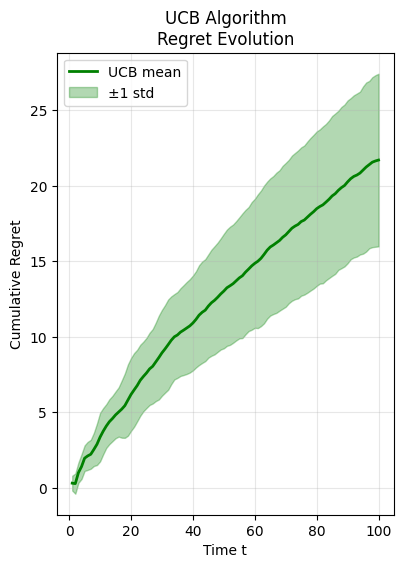

In [30]:
class UCB:
    def __init__(self, T=100, K=5):
        self.T = T
        self.K = K
        self.arm_counts = np.zeros(K) 
        self.arm_rewards = np.zeros(K)
        self.rewards = []
        self.actions = []
        self.optimal_arm = np.argmax(means)
        self.mu_star = means[self.optimal_arm]
        
    def get_empirical_mean(self, arm):
        if self.arm_counts[arm] == 0:
            return 0
        return self.arm_rewards[arm] / self.arm_counts[arm]
    
    def get_confidence_bound(self, arm, t):
        if self.arm_counts[arm] == 0:
            return np.inf  
        return np.sqrt(2 * np.log(t) / self.arm_counts[arm])
    
    def get_ucb_value(self, arm, t):
        return self.get_empirical_mean(arm) + self.get_confidence_bound(arm, t)
    
    def run(self):
        for t in range(1, self.T + 1):
            ucb_values = [self.get_ucb_value(arm, t) for arm in range(self.K)]
            
            chosen_arm = np.argmax(ucb_values)
            
            reward = MAB[chosen_arm].sample()
            
            self.arm_counts[chosen_arm] += 1
            self.arm_rewards[chosen_arm] += reward
            self.rewards.append(reward)
            self.actions.append(chosen_arm)
    
    def calculate_regret_evolution(self):
        cumulative_regret = []
        optimal_reward_so_far = 0
        actual_reward_so_far = 0
        
        for t in range(self.T):
            optimal_reward_so_far += self.mu_star
            actual_reward_so_far += self.rewards[t]
            regret_t = optimal_reward_so_far - actual_reward_so_far
            cumulative_regret.append(regret_t)
            
        return cumulative_regret

num_experiments = 100
T = 100
all_regrets_ucb = np.zeros((num_experiments, T))

print("Running UCB experiments...")
print("True arm probabilities:", [f"{m:.3f}" for m in means])
print(f"Optimal arm: {np.argmax(means)} (μ* = {np.max(means):.3f})")

for exp in range(num_experiments):
    for i, mab in enumerate(MAB):
        mab.local_random = np.random.RandomState(exp * K + i)
    
    ucb = UCB(T=T, K=5)
    ucb.run()
    
    regret_evolution = ucb.calculate_regret_evolution()
    all_regrets_ucb[exp, :] = regret_evolution

plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
mean_regret_ucb = np.mean(all_regrets_ucb, axis=0)
std_regret_ucb = np.std(all_regrets_ucb, axis=0)
time_steps = range(1, T+1)

plt.plot(time_steps, mean_regret_ucb, 'g-', linewidth=2, label='UCB mean')
plt.fill_between(time_steps, 
                 mean_regret_ucb - std_regret_ucb, 
                 mean_regret_ucb + std_regret_ucb, 
                 alpha=0.3, color='green', label='±1 std')
plt.xlabel('Time t')
plt.ylabel('Cumulative Regret')
plt.title('UCB Algorithm\nRegret Evolution')
plt.legend()
plt.grid(True, alpha=0.3)


**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

Ici, c'est à vous de réfléchir à la meilleure représentation de ces valeurs.

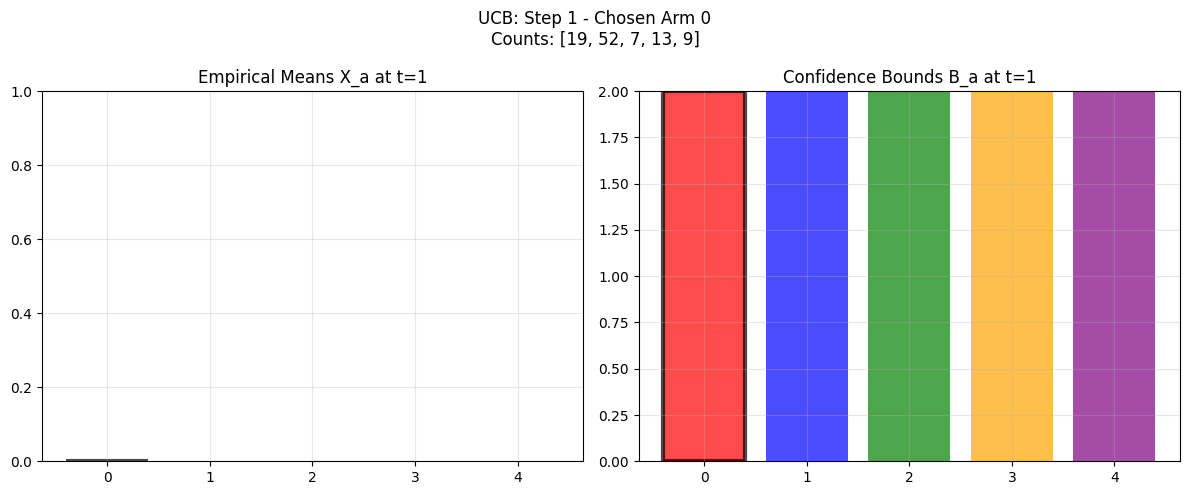

In [31]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class UCBWithHistory(UCB):
    def __init__(self, T=100, K=5):
        super().__init__(T, K)
        self.X_history = []
        self.B_history = []
        self.chosen_arms = []
    
    def run(self):
        for t in range(1, self.T + 1):
            X_current = [self.get_empirical_mean(arm) for arm in range(self.K)]
            B_current = [min(2, self.get_confidence_bound(arm, t)) for arm in range(self.K)]
            ucb_values = [self.get_ucb_value(arm, t) for arm in range(self.K)]
            
            self.X_history.append(X_current.copy())
            self.B_history.append(B_current.copy())
            
            chosen_arm = np.argmax(ucb_values)
            self.chosen_arms.append(chosen_arm)
            
            reward = MAB[chosen_arm].sample()
            self.arm_counts[chosen_arm] += 1
            self.arm_rewards[chosen_arm] += reward
            self.rewards.append(reward)
            self.actions.append(chosen_arm)

for i, mab in enumerate(MAB):
    mab.local_random = np.random.RandomState(42)

ucb_anim = UCBWithHistory()
ucb_anim.run()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

def animate(frame):
    ax1.clear()
    ax2.clear()
    
    t = frame + 1
    X_vals = ucb_anim.X_history[frame]
    B_vals = ucb_anim.B_history[frame]
    chosen_arm = ucb_anim.chosen_arms[frame]
    
    bars1 = ax1.bar(range(K), X_vals, color=colors, alpha=0.7)
    bars1[chosen_arm].set_edgecolor('black')
    bars1[chosen_arm].set_linewidth(3)

    ax1.set_title(f'Empirical Means X_a at t={t}')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(range(K))
    ax1.grid(True, alpha=0.3)
    
    bars2 = ax2.bar(range(K), B_vals, color=colors, alpha=0.7)
    bars2[chosen_arm].set_edgecolor('black')
    bars2[chosen_arm].set_linewidth(3)
    
    ax2.set_title(f'Confidence Bounds B_a at t={t}')
    ax2.set_ylim(0, 2)
    ax2.set_xticks(range(K))
    ax2.grid(True, alpha=0.3)
    
    fig.suptitle(f'UCB: Step {t} - Chosen Arm {chosen_arm}\nCounts: {[int(c) for c in ucb_anim.arm_counts]}')
    plt.tight_layout()

anim = animation.FuncAnimation(fig, animate, frames=len(ucb_anim.X_history), 
                             interval=300, repeat=True)

anim.save('ucb_animation.gif', writer='pillow', fps=10)


# The animation is in the folder /gifs

# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?**

Les lois Beta sont adaptées pour modéliser l'efficacité d'un vaccin quand on ne la connaît pas encore. Car quand on démarre avec une distribution uniforme Beta(1,1) -on ne sait pas donc tous les taux d'efficacité entre 0 et 1 sont également probables.

À chaque fois qu'on teste un vaccin, on met à jour nos croyances : si le patient est immunisé, on ajoute 1 au paramètre α (succès), sinon on ajoute 1 au paramètre β (échecs). On a donc après 10 tests avec 7 succès, on obtient Beta(8,4) avec une probabilité estimée de 8/12 ≈ 0.67.

Plus on accumule d'observations, plus notre incertitude diminue et la distribution se resserre autour de la vraie valeur.

**Comment se passent l'exploration et l'exploitation ?**

Dans Thompson Sampling, l'exploration et l'exploitation se font grâce à l'échantillonnage aléatoire des distributions Beta qu'on a expliqué avant.

**L'exploitation** : Les vaccins qui ont montré de bons résultats ont des distributions Beta concentrées autour de valeurs élevées. Quand on échantillonne, on a donc plus de chances de tirer une valeur haute et de choisir ces vaccins.

**L'exploration** : Les vaccins peu testés ont des distributions Beta très larges (beaucoup d'incertitude). Même si leur moyenne empirique est faible, l'échantillonnage peut parfois donner des valeurs élevées, ce qui nous pousse à les tester encore.

**Implémentez l'algorithme et tracez l'évolution du regret.**

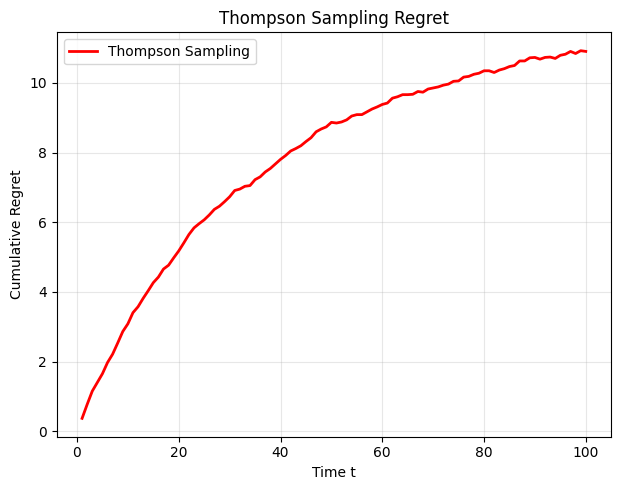


Final Results:
Thompson: 10.90 ± 6.02
UCB: 21.69 ± 5.71
Naive: 16.22 ± 12.51


In [34]:
class ThompsonSampling:
    def __init__(self, T=100, K=5):
        self.T = T
        self.K = K
        self.alpha = np.ones(K)
        self.beta = np.ones(K)
        self.rewards = []
        self.actions = []
        self.optimal_arm = np.argmax(means)
        self.mu_star = means[self.optimal_arm]
        
    def run(self):
        for t in range(self.T):
            theta_samples = [np.random.beta(self.alpha[arm], self.beta[arm]) 
                           for arm in range(self.K)]
            
            chosen_arm = np.argmax(theta_samples)
            
            reward = MAB[chosen_arm].sample()
            
            if reward == 1:
                self.alpha[chosen_arm] += 1  # succes
            else:
                self.beta[chosen_arm] += 1   # echec
                
            self.rewards.append(reward)
            self.actions.append(chosen_arm)
    
    def calculate_regret_evolution(self):
        cumulative_regret = []
        optimal_reward_so_far = 0
        actual_reward_so_far = 0
        
        for t in range(self.T):
            optimal_reward_so_far += self.mu_star
            actual_reward_so_far += self.rewards[t]
            regret_t = optimal_reward_so_far - actual_reward_so_far
            cumulative_regret.append(regret_t)
            
        return cumulative_regret

num_experiments = 100
T = 100
all_regrets_thompson = np.zeros((num_experiments, T))


for exp in range(num_experiments):
    np.random.seed(exp)
    for i, mab in enumerate(MAB):
        mab.local_random = np.random.RandomState(exp * K + i)
    
    thompson = ThompsonSampling(T=T, K=5)
    thompson.run()
    
    regret_evolution = thompson.calculate_regret_evolution()
    all_regrets_thompson[exp, :] = regret_evolution

final_regrets_ucb = all_regrets_ucb[:, -1]
final_regrets_naive = all_regrets[:, -1]
final_regrets_thompson = all_regrets_thompson[:, -1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mean_regret_thompson = np.mean(all_regrets_thompson, axis=0)
time_steps = range(1, T+1)
plt.plot(time_steps, mean_regret_thompson, 'r-', linewidth=2, label='Thompson Sampling')
plt.xlabel('Time t')
plt.ylabel('Cumulative Regret')
plt.title('Thompson Sampling Regret')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Thompson: {np.mean(final_regrets_thompson):.2f} ± {np.std(final_regrets_thompson):.2f}")
print(f"UCB: {np.mean(final_regrets_ucb):.2f} ± {np.std(final_regrets_ucb):.2f}")
print(f"Naive: {np.mean(final_regrets_naive):.2f} ± {np.std(final_regrets_naive):.2f}")

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.

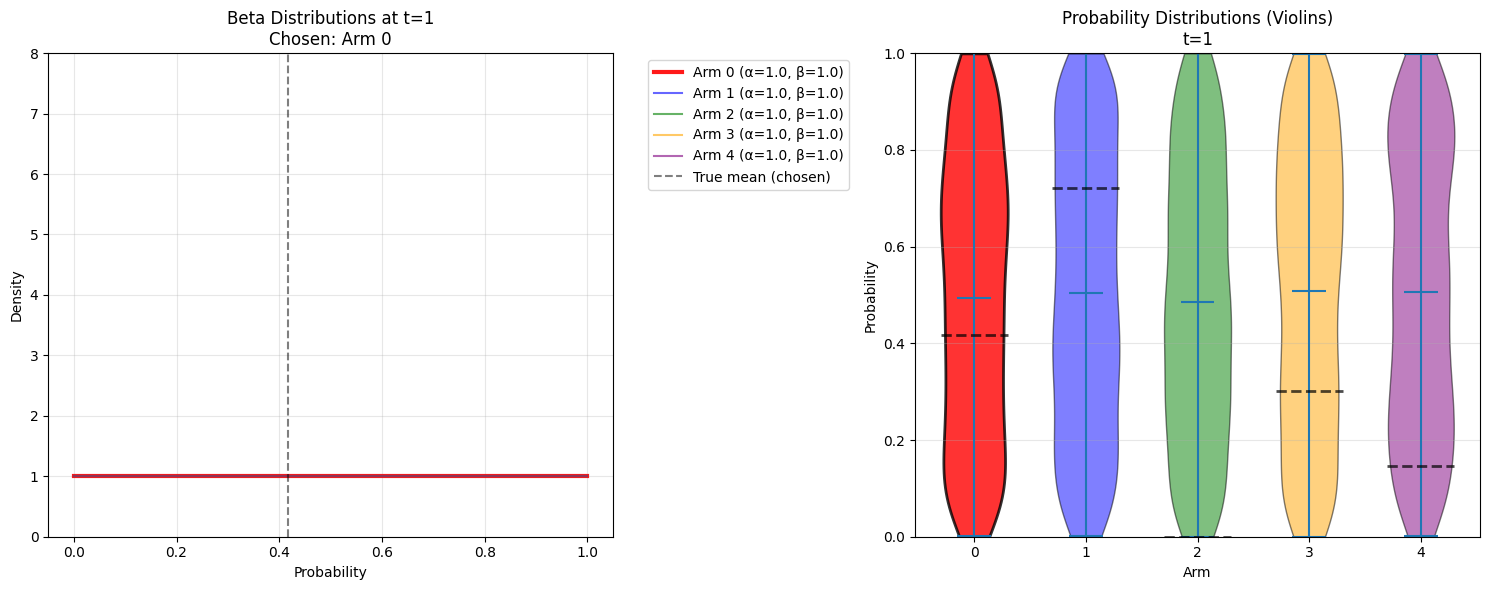

In [38]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats

class ThompsonSamplingWithHistory:
    def __init__(self, T=100, K=5):
        self.T = T
        self.K = K
        self.alpha = np.ones(K)
        self.beta = np.ones(K)
        self.alpha_history = []
        self.beta_history = []
        self.chosen_arms = []
        self.rewards = []
        self.actions = []
        
    def run(self):
        for t in range(self.T):
            self.alpha_history.append(self.alpha.copy())
            self.beta_history.append(self.beta.copy())
            
            theta_samples = [np.random.beta(self.alpha[arm], self.beta[arm]) 
                           for arm in range(self.K)]
            
            chosen_arm = np.argmax(theta_samples)
            self.chosen_arms.append(chosen_arm)
            
            reward = MAB[chosen_arm].sample()
            
            if reward == 1:
                self.alpha[chosen_arm] += 1
            else:
                self.beta[chosen_arm] += 1
                
            self.rewards.append(reward)
            self.actions.append(chosen_arm)

np.random.seed(42)
for i, mab in enumerate(MAB):
    mab.local_random = np.random.RandomState(42 + i)

thompson_anim = ThompsonSamplingWithHistory()
thompson_anim.run()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple']
x_vals = np.linspace(0, 1, 1000)

def animate(frame):
    ax1.clear()
    ax2.clear()
    
    t = frame
    alphas = thompson_anim.alpha_history[t]
    betas = thompson_anim.beta_history[t]
    chosen_arm = thompson_anim.chosen_arms[t] if t < len(thompson_anim.chosen_arms) else None
    
    for arm in range(5):
        dist = stats.beta(alphas[arm], betas[arm])
        y_vals = dist.pdf(x_vals)
        
        color = colors[arm]
        linewidth = 3 if arm == chosen_arm else 1.5
        alpha = 0.9 if arm == chosen_arm else 0.6
        
        ax1.plot(x_vals, y_vals, color=color, linewidth=linewidth, alpha=alpha,
                label=f'Arm {arm} (α={alphas[arm]:.1f}, β={betas[arm]:.1f})')
    
    ax1.axvline(x=means[chosen_arm] if chosen_arm is not None else 0, 
                color='black', linestyle='--', alpha=0.5, label='True mean (chosen)')
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Beta Distributions at t={t+1}\nChosen: Arm {chosen_arm}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 8)
    
    violin_data = []
    positions = []
    
    for arm in range(5):
        samples = np.random.beta(alphas[arm], betas[arm], 1000)
        violin_data.append(samples)
        positions.append(arm)
    
    parts = ax2.violinplot(violin_data, positions=positions, widths=0.6, showmeans=True)
    
    for i, pc in enumerate(parts['bodies']):
        color = colors[i]
        pc.set_facecolor(color)
        pc.set_alpha(0.8 if i == chosen_arm else 0.5)
        pc.set_edgecolor('black')
        pc.set_linewidth(2 if i == chosen_arm else 1)
    
    for arm in range(5):
        ax2.hlines(means[arm], arm-0.3, arm+0.3, colors='black', 
                  linestyles='dashed', alpha=0.7, linewidth=2)
    
    ax2.set_xlabel('Arm')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Probability Distributions \nt={t+1}')
    ax2.set_xticks(range(5))
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()


anim = animation.FuncAnimation(fig, animate, frames=len(thompson_anim.alpha_history), 
                             interval=400, repeat=True)
anim.save('thompson_violin_animation.gif', writer='pillow', fps=10)

# The animation is in the folder /gifs